---
layout: default
title: "Deep Learning - CNN - Neural style transfer"
categories: deeplearning
permalink: /ML41/
order: 41
comments: true
---

In [2]:
%pylab --no-import-all inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')
plt.rcParams["mathtext.fontset"] = "cm"

Populating the interactive namespace from numpy and matplotlib


# Neural style transfer 

Neural style transfer is one of the most exciting applications of convolutional neural network and consists in taking an input picture with some content (c) and applying to it the *style* (s) of another picture to generate a new picture (g). (<a href="#fig:vangogify">figure below</a>).

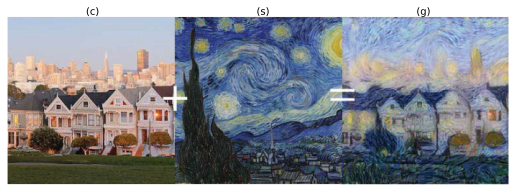

In [3]:
fig, ax = plt.subplots(figsize=(9, 4), dpi=100)
img = plt.imread('./data/img/styletransfer.jpeg')
ax.imshow(img)
ax.set_axis_off()
for x, l in zip([0.17, .51, .83], ['(c)', '(s)', '(g)']):
    ax.text(x, 1, l, transform=ax.transAxes, va='bottom', ha='center')

<i id="fig:vangogify">Left: The Painted Ladies by King of Hearts / Wikimedia Commons / CC-BY-SA-3.0 | Middle: A Starry Night by Vincent van Gogh, c. June 1889 | Right: Image generated by employing the Neural Style Transfer algorithm, [Gatys et al.](https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/Gatys_Image_Style_Transfer_CVPR_2016_paper.pdf)</i>

In order to understand neural style transfer it is necessary to understand what shallows and deep layers of a convolutional neural network are encoding for.

## What are deep convolutional networks learning?
In [Zeiler et al.](https://arxiv.org/pdf/1311.2901.pdf), a deconvolution network is used to map activation units back to their pixel space. This approach is used on the top 9 activation unit on layer 1-3 of a CNN to produce <a href="#fig:cnnencoding">the figure below</a>.

![png](./data/img/cnnencoding.png)

<i id="fig:cnnencoding">From [Zeiler et al.](https://arxiv.org/pdf/1311.2901.pdf): Visualization of features in a fully trained model. For layers 2-5 we show the top 9 activations in a random subset of feature maps across the validation data, projected down to pixel space using our deconvolutional network approach. Our reconstructions are not samples from the model: they are reconstructed patterns from the validation set that cause high activations in a given feature map. For each feature map we also show the corresponding image patches. Note: (i) the the strong grouping within each feature map, (ii) greater invariance at higher layers and (iii) exaggeration of discriminative parts of the image, e.g. eyes and noses of dogs (layer 4, row 1, cols 1). Best viewed in electronic form.</i>

We can clearly see that early layers encode for simpler features like straight lines dividing high contrast areas, while late layers encode for increasingly  more complex features.

## Cost function
Let's define a cost function to build a neural style transfer system. The cost function will be minimized to generate the desired image ($g$). We need to define a cost function $J(g)$ that tells how good is the generated image. To describe how good is $g$ we need to define two parts: 

* $J_\text{content}(c, g)$ measures how similar is the content generated image ($g$) to the input content ($c$)
* $J_\text{style}=(s, g)$ measure how similar is the style of the generated image ($g$) to the style image ($s$)

$$
J(g) = \alpha J_\text{content}(c, g) + \beta J_\text{style}(s, g)
$$

where $\alpha$ and $\beta$ are two hyperparameters that weight how important is the content versus the style part of the transfer.

To find the generated image $g$ we would initialize $g$ randomly (e.g. $100 \times 100 \times 3$ image) and then use gradient descent to minimize $J(g)$ and update the pixel values of $g$.

$$g := g - \frac{\partial J(g)}{\partial g}$$

### Content cost function
Let's say that you use hidden layer $l$'s activation to measure content: using a shallow layer will force $g$ to be very similar to $c$, while using a too deep layer will not ensure that $g$ is similar enough to $c$ in its ensemble. $g$ will probably contain elements of $c$, but maybe their size or maybe their position will not adhere to $c$. The layer $l$ needs to be set manually and usually is chosen to be among the middle layers of a neural network.

Suppose we use a pre-trained ConvNet, for example the VGG network. We need to define a cost function for the similarity of content between $c$ and $g$. Let $a^{(c)[l]}$ and $a^{(g)[l]}$ be the activation of layer $l$ on the images, if $a^{(c)[l]}$ and $a^{(g)[l]}$ are similar, both images have similar content. So we just need to determine how distant are $g$ and $c$ and our cost function $J_\text{content}(c,g)$ can simply be 

$$
J_\text{content}(c,g)= \| a^{(c)[l]} - a^{(g)[l]} \|^2
$$

## Style cost function
As for the content encoding, let's say you use layer $l$'s activation to measure "style" and suppose we define the style as the covariance between activations across channels in a layer. Layer $l$ has three dimensions $n_H$, $n_W$ and $n_C$; Consider Layer 2 of <a href="#fig:cnnencoding">the figure above</a> and focus on pixel space: saying that activations display covariance means that a unit is activates together with another one. For example, an unit that detects vertical stripes activates together with a unit that detects shades of orange. When found together (co-varying) these features define the style of an image that will have vertical orange stripes .

To calculate covariance of unit activation in layer $l$ we compute what is called **gram matrix**, although we will refer to it as the style matrix. Let $a_{i,j,k}^{[l]}$ be the activation at position $i,j,k$ at hidden layer $l$. We calculate the matrix $G^{[l]}$ which is an $n_c^{[l]} \times n_c^{[l]}$ matrix, that compares all channels between themselves. For example, $G_{kk'}^{[l]}$ will measure the covariance between the activations in channel $k$ and those in channel $k'$ where $k,k' \in [1,\dots,n_c]$. The gram matrix $G^{[l]}_{kk'}$ is computed as 

$$G^{[l]}_{kk'} = \sum_{i=1}^{n_H^{[l]}} \sum_{j=1}^{n_W^{[l]}} a^{[l]}_{ijk} a^{[l]}_{ijk'}$$

Since we multiply $a_{ijk}^{[l]} \cdot a_{ijk}^{[l]}$ the value in the style matrix will be large if they display covariance and small if they do not. In order to compare the style ($s$) and generated image ($g$) we need to compare the style matrix for both of them

$$
\begin{split}
& G^{(s)[l]}_{kk'} = \sum_{i=1}^{n_H^{[l]}} \sum_{j=1}^{n_W^{[l]}} a^{(s)[l]}_{ijk} a^{(s)[l]}_{ijk'} \\
& G^{(g)[l]}_{kk'} = \sum_{i=1}^{n_H^{[l]}} \sum_{j=1}^{n_W^{[l]}} a^{(g)[l]}_{ijk} a^{(g)[l]}_{ijk'}
\end{split}
$$

Finally, since we have an element that encodes for the style of the style ($s$) and generated ($g$) images, the style cost function $J_\text{style}^{[l]}(s,g)$ can be defined as the squared difference between the style matrices:

$$
\begin{split}
J_\text{style}^{[l]}(s,g) & = \left \| G^{(s)[l]} - G^{(g)[l]} \right \|^2_F \\
&= \sum_k \sum_{k'} \left( G^{(s)[l]}_{kk'} - G^{(g)[l]}_{kk'} \right)^2
\end{split}
$$

which is the **Forbenius norm** between the style matrices. Sometimes, a normalization constant is employed which is not essential since $J_\text{style}(s,g)$ is weighted anyway by the hyperparamter $\beta$

$$
J_\text{style}^{[l]}(s,g)  = \frac{1}{\left(2 n_W^{[l]}n_H^{[l]}n_C^{[l]} \right)^2} \sum_k \sum_{k'} \left( G^{(s)[l]}_{kk'} - G^{(g)[l]}_{kk'} \right)^2
$$

Finally, more pleasing results are obtained, when the style cost is computed from multiple layers

$$
J_\text{style}(s,g) = \sum_l \lambda^{[l]} J_\text{style}^{[l]}(s,g)
$$

where $\lambda$ is a set of hyperparameters that weight the contribution of different layers.